In [19]:
%pip install pandas prophet matplotlib

Note: you may need to restart the kernel to use updated packages.


In [21]:
import pandas as pd

df = pd.read_csv('../dataset/2015-2024-monthly-tourist-arrivals-sl-csv.csv')

# Drop the unnecessary PercentageChange column
df = df.drop(columns=['PercentageChange'], errors='ignore')

# Convert 'Year' and 'Month' into a single date column
df['ds'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'], format='%Y-%B')

# Rename 'Arrivals' to 'y' as required by Prophet
df.rename(columns={'Arrivals': 'y'}, inplace=True)

# Keep only the columns required for Prophet
df = df[['ds', 'y']]

# Display the data
df.head()



,ds,y
0,2014-01-01,146575
1,2014-02-01,141878
2,2014-03-01,133048
3,2014-04-01,112631
4,2014-05-01,90046


In [40]:
from prophet import Prophet

# Reinitialize the model with seasonalities
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False,
                changepoint_prior_scale=0.1, n_changepoints=30)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
# changepoints = ['2019-04-21', '2020-03-01', '2022-03-22', '2023-02-25']
# model = Prophet(changepoints=changepoints)

# Train the model
model.fit(df)

14:14:11 - cmdstanpy - INFO - Chain [1] start processing
14:14:11 - cmdstanpy - INFO - Chain [1] done processing


In [41]:
# Define the number of months to forecast into the future
future_periods = 24  # Change this value as needed

# Create future dates dataframe
future = model.make_future_dataframe(periods=future_periods, freq='M')

# Make predictions
forecast = model.predict(future)

# Display the forecast
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

/usr/local/python/3.12.1/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


,ds,yhat,yhat_lower,yhat_upper
147,2026-03-31,-249587.659188,-297251.554515,-202000.925818
148,2026-04-30,-494806.917747,-537744.880534,-443778.263334
149,2026-05-31,-276657.155146,-323017.961842,-226885.874608
150,2026-06-30,-423098.026581,-468509.551577,-378679.495108
151,2026-07-31,-223465.609052,-269841.681393,-174954.332532


/usr/local/python/3.12.1/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/python/3.12.1/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


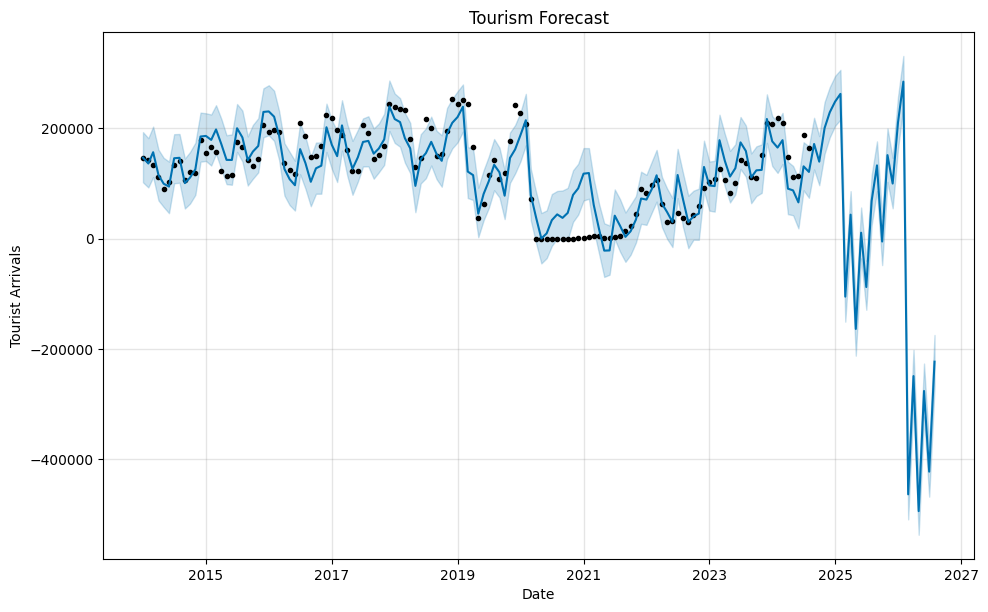

In [42]:
import matplotlib.pyplot as plt

# Plot the forecast
fig = model.plot(forecast)
plt.title('Tourism Forecast')
plt.xlabel('Date')
plt.ylabel('Tourist Arrivals')
plt.show()


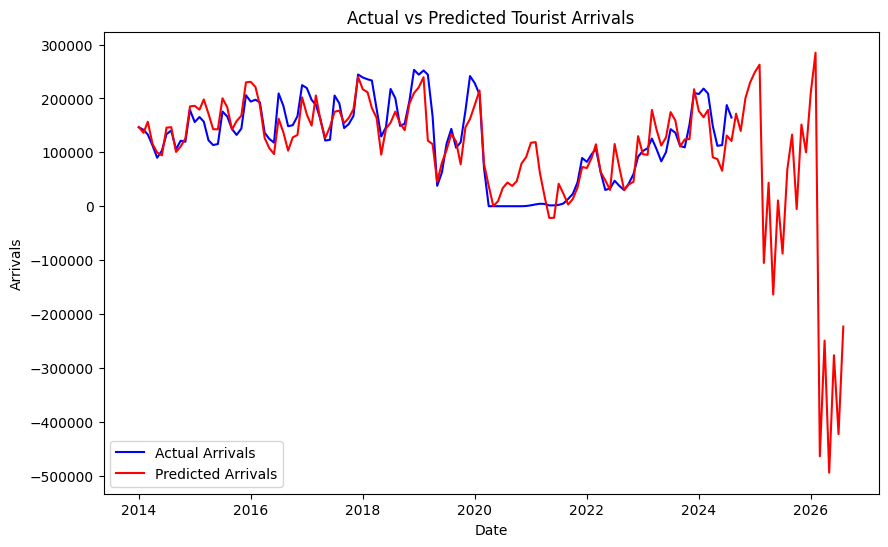

In [43]:
# Plot actual vs predicted values
fig, ax = plt.subplots(figsize=(10, 6))

# Plot actual values
ax.plot(df['ds'], df['y'], label='Actual Arrivals', color='blue')

# Plot predicted values
ax.plot(forecast['ds'], forecast['yhat'], label='Predicted Arrivals', color='red')

# Add labels and legend
ax.set_title('Actual vs Predicted Tourist Arrivals')
ax.set_xlabel('Date')
ax.set_ylabel('Arrivals')
ax.legend()

plt.show()


In [44]:
from sklearn.metrics import mean_absolute_error

# Only compare on dates for which we have actual data
actual = df['y']
predicted = forecast.loc[forecast['ds'].isin(df['ds']), 'yhat']

# Calculate MAE
mae = mean_absolute_error(actual, predicted)
print(f"Mean Absolute Error: {mae}")


Mean Absolute Error: 26503.991487202373
